# Correlation

The association between two continuous variables can be quantified by the correlation coefficient, $r$. Here we explain Pearson correlation, which measures the strength of the linear relationship between two variables. If you systematically control the X variable (e.g. concentration, time, dose, etc.), you should calculate _linear regression_ rather than correlation (see Chapter 33). In addition, X and Y are totally symmetrical in correlation calculations, but not with linear regression.

Correlation is a measure of the amount of relatedness between two measured variables. A correlation measure typically goes from -1 (anti-correlation) to 1 (correlation), where 0 is the absence of correlation (independence). When two variables show a very large correlation, one can be said to be a **predictor** of the other, in the sense that knowing the value of one of the two variable allows us to make a reasonnable guess about the value of the second variable. Another way of looking at this relationship is to see those variable as **redundant**, in the sense that they carry the same information : knowing the value of both variable does not bring much more insight compared to knowing the value of only one.

Note that, if you quantify how closely two alternative assay methods agree, you should use special methods such as the [Bland-Altman plot](https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot).

## Correlation analysis

In [13]:
import numpy as np

from scipy import stats
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# example data from the book, page 319
insulin_sensitiv = np.array([250, 220, 145, 115, 230, 200, 330, 400, 370, 260, 270, 530, 375])
C2022_fatacids = np.array([17.9, 18.3, 18.3, 18.4, 18.4, 20.2, 20.3, 21.8, 21.9, 22.1, 23.1, 24.2, 24.4])

### Descriptive statistics

In [15]:
print(f"The mean of the insulin sensitivity index = {np.mean(insulin_sensitiv):.1f} +/- SD of {np.std(insulin_sensitiv,ddof=1):.1f}")

The mean of the insulin sensitivity index = 284.2 +/- SD of 113.9


In [16]:
stats.describe(insulin_sensitiv)

DescribeResult(nobs=13, minmax=(115, 530), mean=284.2307692307692, variance=12970.192307692307, skewness=0.5429430677319255, kurtosis=-0.19429352446593473)

In [17]:
stats.describe(C2022_fatacids)

DescribeResult(nobs=13, minmax=(17.9, 24.4), mean=20.71538461538461, variance=5.55474358974359, skewness=0.2382148683128159, kurtosis=-1.3626759485656732)

### Visualization

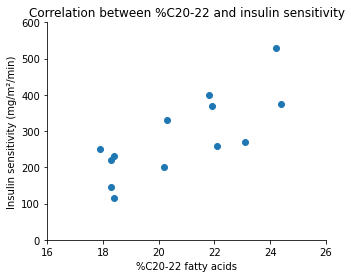

In [18]:
plt.figure(figsize=(5,4))
plt.scatter(C2022_fatacids, insulin_sensitiv)
plt.title('Correlation between %C20-22 and insulin sensitivity')
plt.xlabel('%C20-22 fatty acids')
plt.ylabel('Insulin sensitivity (mg/m²/min)')
plt.axis((16, 26, 0, 600))
sns.despine();

### Proper correlation analysis

In [19]:
r, P_val = stats.pearsonr(C2022_fatacids, insulin_sensitiv)
print(f'Correlation coefficient r = {r:3.2f}')
print(f'P value (two-tailed) = {P_val:5.4f}')

Correlation coefficient r = 0.77
P value (two-tailed) = 0.0021


The null hypothesis is no correlation between variables. If the H0 were true, what is the chance that 13 randomly picked subjects would have an $r$ greater than 0.77 or less than -0.77?

In [20]:
print(f"r² = {r**2:.2f}")

r² = 0.59


$ r^2 $, also called the _coefficient of determination_, is the **fraction of the variance shared between the two variables**. Here, 59% of the variability in insulin tolerance is associated with variability in lipid content. Knowing the lipid content lets you explain 59% of the variance in the insulin sensitivity. That leaves 41% of the variance to be explained by other factors or by measurement error. We can also say that 59% of the variability in lipid content is associated with variability in insulin tolerance.

### How it works

1. Calculate the average of all X values. Same for all Y values. These two averages define a point at the **center of gravity**
2. Compare the position of each point with respect to that center. Substract the average X value from each X value; _the result will be positive for points to the right of the center and negative for points to the left_. Similarly, substract the average Y value from each Y value.
3. Standardize those X distances by dividing by the SD of all X values, same for Y values. These ratios are fractions without unit.
4. Multiply the two standardized distances for each data point. _The product will be positive for points that are northeast or southwest._
5. Add up all the products.
6. Account for sample size by dividing the sum by $(n-1)$, where $n$ is the number of XY pairs.

If X and Y are not correlated, then the positive products will approximately balance out the negative ones, and the correlation coefficient will be close to zero.

$$ \text{cov} = \frac{1}{n} \sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y}) $$

$$ \rho = \frac{\text{cov}}{\sigma(x).\sigma(y)} $$

It computes basically the ratio of the variability due to codependence to the independent variability.

In [21]:
np.corrcoef(C2022_fatacids, insulin_sensitiv)

array([[1.        , 0.77000254],
       [0.77000254, 1.        ]])

In [22]:
# covariance is the mean of the products (xi-X)(yi-Y)
np.cov(C2022_fatacids, insulin_sensitiv)

array([[5.55474359e+00, 2.06679487e+02],
       [2.06679487e+02, 1.29701923e+04]])

In [23]:
def pearson_r(x,y, quiet=True):
    """
    Computes Pearson correlation coefficient between XYpairs.
    """
    cov_matrix  = np.cov(x,y)     # returns 2D array with [0,1] and [1,0] the covariances,
                                  # [0,0] the variance of x, and [1,1] the variance of y
    cor_matrix = np.corrcoef(x,y) # returns the correlation matrix

    cov = cov_matrix[0,1]
    std_x=cov_matrix[0,0]**0.5    # because variance is s²
    std_y=cov_matrix[1,1]**0.5
    r = cov / (std_x * std_y)
    if not quiet : print(r)

    r = cor_matrix[0,1]              # gives the same result as above
    if not quiet:
        print(r)
    else:
        return r

In [24]:
pearson_r(insulin_sensitiv, C2022_fatacids, quiet=False)

0.7700025428371727
0.7700025428371727


#### Analysis using pingouin package

In [25]:
pg.corr(x=C2022_fatacids, y=insulin_sensitiv) # by default pearson method

,n,r,CI95%,p-val,BF10,power
pearson,13,0.770003,"[0.38, 0.93]",0.002077,23.947,0.912954


#### Spearman

The **nonparametric Spearman correlation** adds one step (explained in chapter 41). The Spearman correlation coefficient, **robust to outliers**, is a non-parametric measure of the monotonicity of the relationship between two datasets. Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed. Correlations of -1 or +1 imply an exact negative and positive monotonic relationship, respectively. Mathematically, the Spearman correlation coefficient is defined as the Pearson correlation coefficient between the rank variables.

Spearman's correlation coefficient corresponds to Pearson's correlation coefficient, but on the **ranks** of observations rather than their values. Spearman correlation coefficient is used to describe the correlation between two variables when their relation is *monotonic* (i.e. it goes in a single direction: if it is increasing it is always increasing, it never goes down) but non linear (e.g. an exponential relationship). The formula to calculate the Spearman's rank correlation coefficients  between two random variables **X** and **Y** associated to n individual drawns is:

$$\rho=1-\frac{\sum d_{i}^{2}}{n^{3}-n}$$

Where i is the individual number, n the number of individuals and $d_i$ defined as follow:

$d_i=rank(x_i)-rank(y_i)$

Where of course $x_i$ and $y_i$ are the realization of **X** and **Y** for individual i.

In [26]:
stats.spearmanr(C2022_fatacids, insulin_sensitiv)

SpearmanrResult(correlation=0.7438044752782768, pvalue=0.0035581937201355457)

In [27]:
pg.corr(x=C2022_fatacids, y=insulin_sensitiv, method="spearman")

,n,r,CI95%,p-val,power
spearman,13,0.743804,"[0.33, 0.92]",0.003558,0.877297


#### Kendall tau correlation coefficient

You have already seen that you could define a correlation coefficient in multiple manners using multiple metrics : multiplicative distances to the means for Pearson, ranking distances between the two random variables for Spearman. For completness let's rapidly present another way to measure correlation: Kendall tau.

Kendal tau is based on the concept of concordant or discordant pairs. A concordant pair is a pair of individual i and j, $i<j$, for which the order relation between the two random variables stands : either $x_i>x_j$ and $y_i>y_j$ or $x_i<x_j$ and $y_i<y_j$. Discordant pairs have opposite signs between x and y.

The coefficient is defined as follow:

$$\tau=\frac{\text{number of concordant pairs}-\text{number of discordant pairs}}{\frac{n(n-1)}{2}}$$

Obviously this coefficient is comprised between -1 and 1, 0 meaning no correlation (indeed there is a total of $\frac{n(n-1)}{2}$ unique pairs).

A rank version also exists (which is mathematically equivalent to the expression above):

$$\tau_{rank}=\frac{2}{n(n-1)}\sum_{i<j} sgn(x_i-x_j)sgn(y_i-y_j)$$

Both the Spearman and and Pearson correlation coefficent are relying on distances, which means they are sensitive to the intensity of the error term and to outliers.  Kendall tau is way less influenced by the scale of the variability since it relies only on an order relation.


In [28]:
print('Kendall_tau: {0:.3f}, Kendall_tau_rank: {1:.3f}'.format(
    stats.kendalltau(C2022_fatacids, insulin_sensitiv)[0],
    stats.mstats.kendalltau(C2022_fatacids, insulin_sensitiv)[0]))

Kendall_tau: 0.520, Kendall_tau_rank: 0.520


In [29]:
pg.corr(x=C2022_fatacids, y=insulin_sensitiv, method="kendall")

,n,r,CI95%,p-val,power
kendall,13,0.519524,"[-0.04, 0.83]",0.014306,0.468205


##### Linear, monotonic and non-monotonic functions

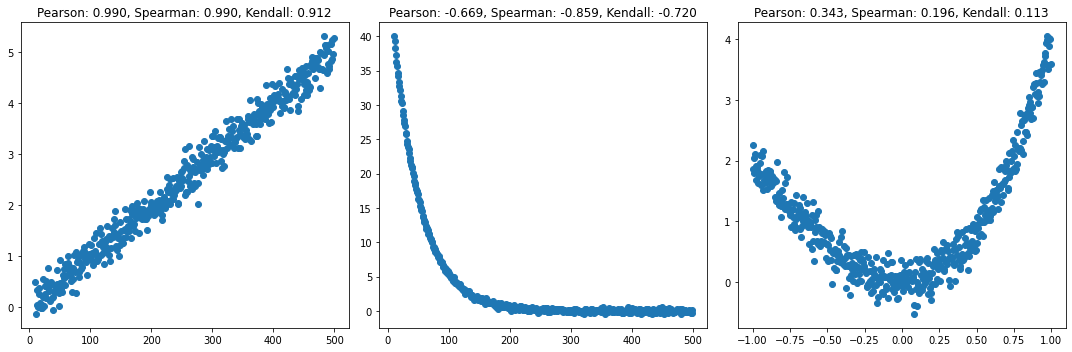

In [30]:
sigma=1./5

linear=[[u,(u)/100+sigma*np.random.randn()] for u in range(10,500)]
monotonic=[[u,50*(0.8**(u/10))+sigma*np.random.randn()] for u in range(10,500)]
non_monotonic=[[u,(u)**3+3*u**2+sigma*np.random.randn()] for u in np.arange(-1,1,1./250)]

together=[linear,monotonic,non_monotonic]
plt.subplots(133,figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    x=[u[0] for u in together[i]]
    y=[u[1] for u in together[i]]
    plt.scatter(x,y)
    plt.title('Pearson: {0:.3f}, Spearman: {1:.3f}, Kendall: {2:.3f}'.format(
        stats.pearsonr(x,y)[0],##just like that
        stats.spearmanr(x,y)[0],
        stats.kendalltau(x,y)[0]))
plt.tight_layout()    
plt.show()

## Confidence Interval

Assuming that the data were randomly sampled from a larger population, there is a 95% chance that this range includes the population correlation coefficient.

### Fisher's r-to-z transformation

The computation of the parametric confidence interval on the population value of Pearson's correlation _r_ is complicated by the fact that the **sampling distribution of r is not normally distributed**. The solution lies with [Fisher's z' transformation] (https://en.wikipedia.org/wiki/Fisher%5ftransformation) described in the section on the sampling distribution of Pearson's r:

1. Convert r to z (Fisher's Z-score) $ z = 0.5 . \ln \frac{1+r}{1-r} = \text{arctanh}(r) $
2. Compute a confidence interval in terms of z
3. Convert the confidence interval back to r

The $z$ variable is normally distributed under $H_0$ : $z=\sqrt{\frac{n-3}{1.06}}F(\rho)$ using the Fisher transformation ($F(\rho)=arctanh(\rho)$).

In [31]:
r, _ = stats.pearsonr(C2022_fatacids, insulin_sensitiv)
z = np.arctanh(r)

The corresponding standard deviation is $\text{SE} = \dfrac{1}{\sqrt{n-3}}$ where $n$ is the sample size.

In [32]:
se = 1/np.sqrt(len(C2022_fatacids)-3)

CI under the transformation, i.e. in _$z$-space_, can be calculated as $\text{ci}_z = z \pm \text{crit}_{\alpha/2} . \text{SE}$ where $\text{crit}_{\alpha/2}$ is the critical value of the **normal distribution** corresponding to the desired confidence level.

In [33]:
alpha = 0.05
crit = stats.norm.ppf(1-alpha/2) # here note that the distribution is not symetrical

These confidence intervals can then be easily converted back to r-space using $ \text{ci}_r = \frac{\exp(2 . \text{ci}_z) - 1}{\exp(2 . \text{ci}_z) + 1} = \tanh(\text{ci}_z)$

In [34]:
ci = np.tanh((z-crit*se, z+crit*se))
print(f"The confidence interval of the Pearson's coefficient r = {r:.2f} extends from {ci[0]:.4f} to {ci[1]:.4f}")

The confidence interval of the Pearson's coefficient r = 0.77 extends from 0.3804 to 0.9275


The second method relies on a t-test to evaluate if $\rho$ is significantly different from 0.

Following a permutation  argument (so looking at a null model where you break data correlation/class by creating all the possible arrangements of your data), you can rationalize the usage of the following test statistic: $t=\rho\sqrt{\frac{n-2}{1-\rho^2}}$, which follow a Student's t-distribution under the null hypothesis that $\rho=0$.

#### Parametric confidence intervals using pingouin

In [35]:
pg.compute_esci(
    stat=pg.compute_effsize(x:=insulin_sensitiv, y:=C2022_fatacids, eftype='r'),
    nx=len(x),
    ny=len(y),
    eftype='r'
)

array([0.38, 0.93])

## Bootstrapping analyses

### Confidence Interval using boostrap replicates

In [36]:
def draw_bs_pairs(x, y, func=pearson_r, size=1):
    """
    Perform pairs bootstrap and compute single statistics from the replicates
    """
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))
    # Initialize replicates
    bs_replicates = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds] # go by pairs
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

In [37]:
bs_r = draw_bs_pairs(insulin_sensitiv, C2022_fatacids, func=pearson_r, size=10000)
ci_bs = np.percentile(bs_r, [2.5, 97.5])
print(f"The 95% CI for the correlation coefficient obtained by bootstrap goes from {ci_bs[0]:.3f} to {ci_bs[1]:.3f}")

The 95% CI for the correlation coefficient obtained by bootstrap goes from 0.530 to 0.913


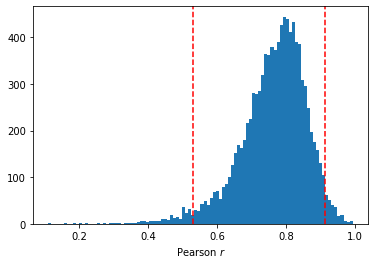

In [38]:
plt.hist(bs_r, bins=100)
plt.xlabel(r"Pearson $r$")
plt.axvline(x=ci_bs[0], color='red', ls='--')
plt.axvline(x=ci_bs[1], color='red', ls='--');

### P value using boostrap replicates

The null hypothesis is that there is no correlation between the two continuous variables. Therefore we can mix up all the values from all the pairs and use permutation. We therefore compare the Pearson correlation coeffiction from the permutation replicates to the observed $r$.

In [39]:
perm_reps_r = np.empty(10000)

for i in range(10000):
    scrambled_insulin = np.random.permutation(insulin_sensitiv)
    perm_reps_r[i] = pearson_r(scrambled_insulin, C2022_fatacids)

p_val_reps = sum(perm_reps_r >= r) / 10000

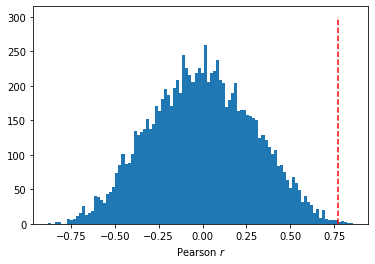

In [40]:
plt.hist(perm_reps_r, bins=100)
plt.vlines(r, ymin=0, ymax=300, colors='red', linestyle='--')
plt.xlabel(r"Pearson $r$");

In [41]:
print(f'P value (two-tailed) using permutation bootstrap replicates = {p_val_reps:5.4f}')

P value (two-tailed) using permutation bootstrap replicates = 0.0011
